In [52]:
import numpy as np
from scipy.optimize import golden
from matplotlib import pyplot as plt

In [53]:
np.random.seed(7)

In [54]:
def calc_F(x, r, n, k, lambda1, lambda2, eps=1e-9):
    sum1 = 0
    for i in range(n):
        for j in range(1, k):
            norm = np.linalg.norm(x[i] - r[j])
            sum1 += 1 / (eps + norm**2)   
    
    sum2 = 0
    for i in range(n):
        sum2 += np.linalg.norm(x[i + 1] - x[i])**2
    
    return lambda1 * sum1 + lambda2 * sum2

In [55]:
def calc_F_grad(x, r, n, k, lambda1, lambda2, eps=1e-9):
    result = np.zeros((n + 1, 2), dtype=np.float64)
    for t in range(1, n):
        sum_ = 0
        for j in range(k):
            denom = (eps + np.linalg.norm(x[t] - r[j])**2)**2
            sum_ += (x[t] - r[j]) / denom
        
        diff1 = x[t] - x[t - 1] 
        diff2 = x[t + 1] - x[t]
        
        val = -2 * lambda1 * sum_ + 2 * lambda2 * (diff1 - diff2)
        
        result[t][0] = val[0]
        result[t][1] = val[1]
        
    return result

In [56]:
def init_x(n, x0, xn):
    x = np.random.uniform(low=0, high=20, size=(n + 1, 2))
    x[0][0] = x0[0]
    x[0][1] = x0[1]
    x[n][0] = xn[0]
    x[n][1] = xn[1]
    return x

def init_r(k):
    return np.random.uniform(low=0, high=20, size=(k, 2))

$F(\mathbf{x}) = \lambda_1 \sum_{i=0}^{n-1} \sum_{j=1}^{k-1} \frac{1}{\epsilon + ||\mathbf{x}_i - \mathbf{r}_j||^2} + \lambda_2 \sum_{i=0}^{n-1} ||\mathbf{x}_{i+1} - \mathbf{x}_i||^2$

$\nabla F(\mathbf{x}) = \left[ \frac{\partial F}{\partial \mathbf{x}_0}, \frac{\partial F}{\partial \mathbf{x}_1}, \ldots, \frac{\partial F}{\partial \mathbf{x}_n} \right]$

$F(\mathbf{x}) = F_1(\mathbf{x}) + F_2(\mathbf{x})$

$F_1(\mathbf{x}) = \lambda_1 \sum_{i=0}^{n-1} \sum_{j=1}^{k-1} \frac{1}{\epsilon + ||\mathbf{x}_i - \mathbf{r}_j||^2}$

$F_2(\mathbf{x}) = \lambda_2 \sum_{i=0}^{n-1} ||\mathbf{x}_{i+1} - \mathbf{x}_i||^2$

$\frac{\partial}{\partial \mathbf{x}_t} \left( \frac{1}{\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2} \right) = - \frac{1}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2} \cdot 2(\mathbf{x}_t - \mathbf{r}_j)$

$\frac{\partial F_1}{\partial \mathbf{x}_t} = -2 \lambda_1 \sum_{j=1}^{k-1} \frac{\mathbf{x}_t - \mathbf{r}_j}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2}$

$\frac{\partial}{\partial \mathbf{x}_t} ||\mathbf{x}_{t+1} - \mathbf{x}_t||^2 = -2(\mathbf{x}_{t+1} - \mathbf{x}_t)$

$\frac{\partial}{\partial \mathbf{x}_t} ||\mathbf{x}_{t} - \mathbf{x}_{t-1}||^2 = 2(\mathbf{x}_{t} - \mathbf{x}_{t-1})$

$\frac{\partial F_2}{\partial \mathbf{x}_t} = 2 \lambda_2 \left( (\mathbf{x}_t - \mathbf{x}_{t-1}) - (\mathbf{x}_{t+1} - \mathbf{x}_t) \right) = 2 \lambda_2 \left(2 \mathbf{x}_t - \mathbf{x}_{t - 1} - \mathbf{x}_{t + 1}\right)$

$\frac{\partial F}{\partial \mathbf{x}_t} = -2 \lambda_1 \sum_{j=1}^{k-1} \frac{\mathbf{x}_t - \mathbf{r}_j}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2} + 2 \lambda_2 \left(\mathbf{x}_t - \mathbf{x}_{t - 1} - \mathbf{x}_{t + 1} \right)$ dla $t = 1, 2, \ldots, n-1$

In [57]:
def minimize_path(n, k, r, x0, xn, lambda1, lambda2, eps, n_iter):
    x = init_x(n, x0, xn)
    r = init_r(k)
    
    F = lambda x: calc_F(x, r, n, k, lambda1, lambda2, eps)
    F_grad = lambda x: calc_F_grad(x, r, n, k, lambda1, lambda2, eps)
    
    costs = [F(x)]
    for iter in range(n_iter):
        grad = F_grad(x)
        gold_result = golden(lambda alpha: F(x + alpha * grad))
        x += gold_result * grad
        costs.append(F(x))
        if np.abs(costs[-2] - costs[-1]) < eps:
            break
    return x, r, costs

In [58]:
r_vec = init_r(50)

results = [minimize_path(20, 50, r_vec, [0, 0], [20, 20], 1, 1, 10e-13, 200) for _ in range(5)]

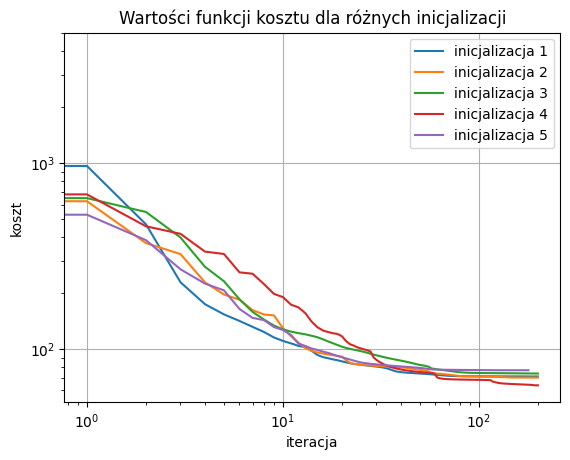

In [59]:
arange = np.arange(0, 401, 1)
plt.loglog(figsize=(12,6))
plt.title("Wartości funkcji kosztu dla różnych inicjalizacji")
plt.xlabel("iteracja")
plt.ylabel("koszt")
for i, result in enumerate(results):
    plt.plot(arange[:len(result[2])], result[2], label=f"inicjalizacja {i + 1}")
plt.legend()
plt.grid()
plt.show()

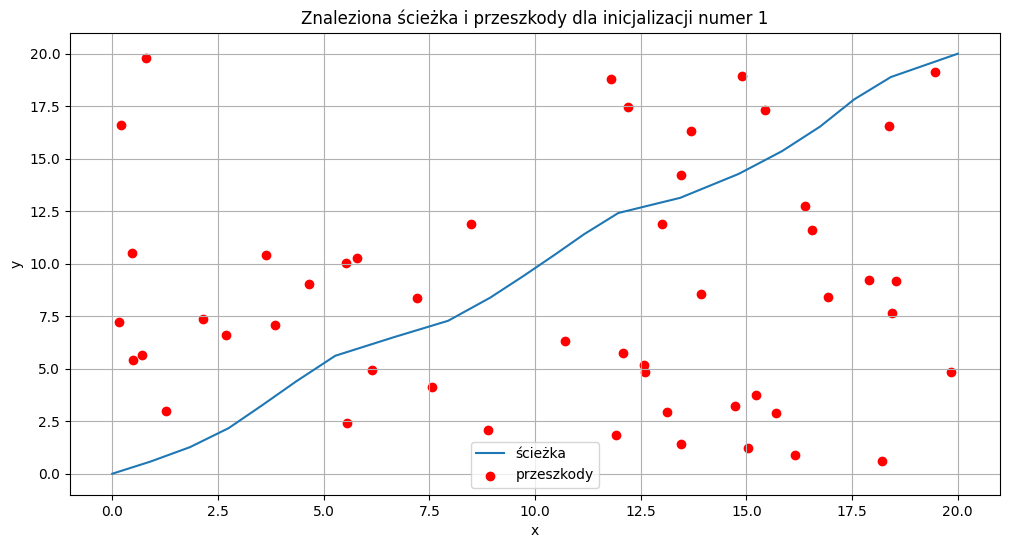

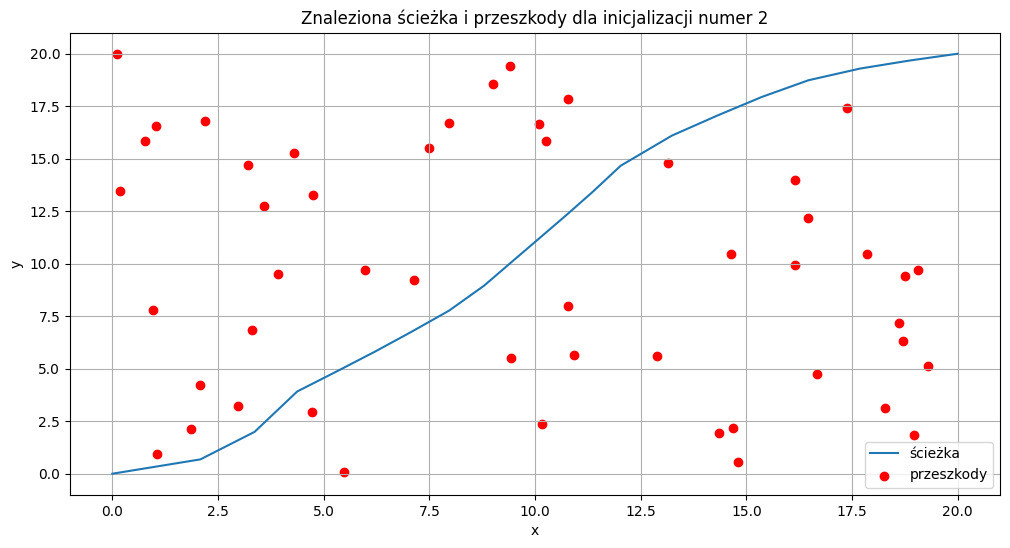

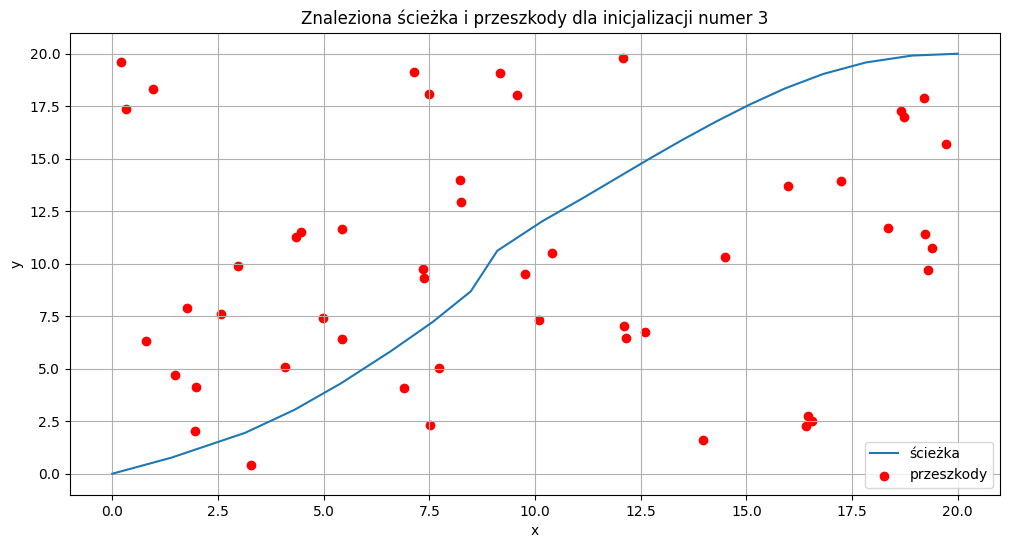

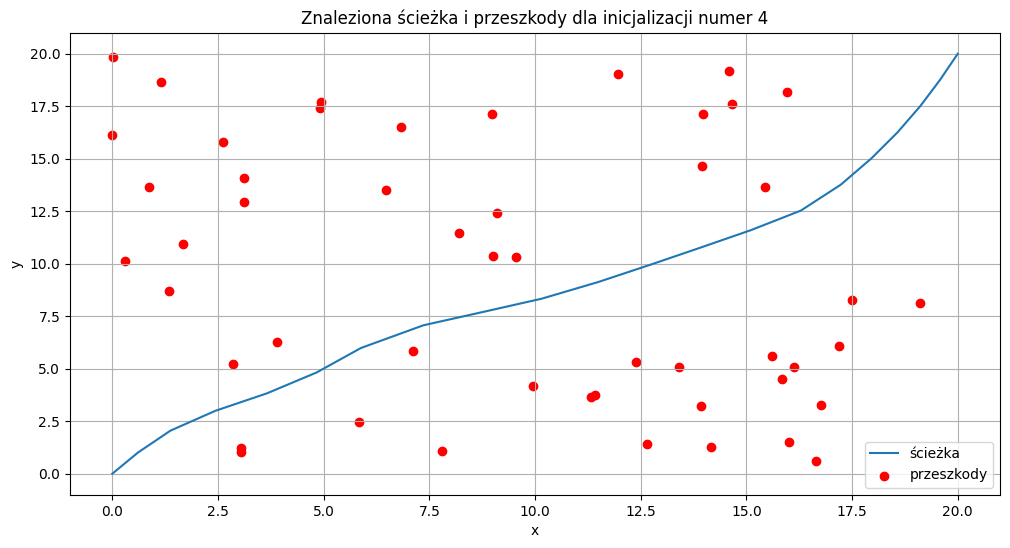

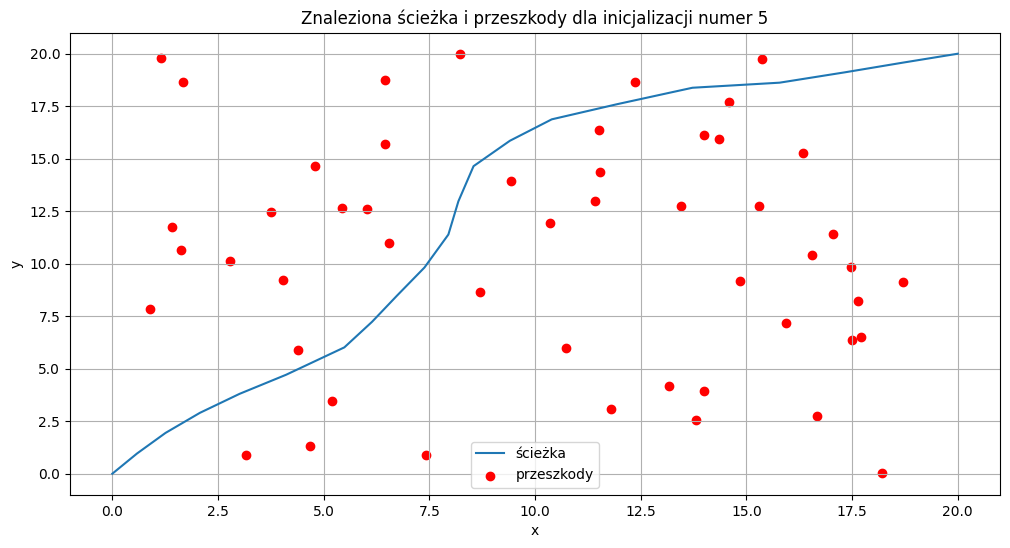

In [60]:
def draw(xs, rs, i):
    plt.figure(figsize=(12,6))
    plt.title(f"Znaleziona ścieżka i przeszkody dla inicjalizacji numer {i}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(xs[:,0], xs[:,1], label="ścieżka")
    plt.scatter(rs[:,0], rs[:,1], label="przeszkody", color="red")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(len(results)):
    draw(results[i][0], results[i][1], i + 1)